In [1]:
from pandas import DataFrame
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [2]:
# Use the WechatBakTool (github project) to export Wechat history)
file_path = r'C:\Users\jhan4\Desktop\LYW.xlsx'
df = pd.read_excel(file_path,usecols=[0,1])
df.columns = ['Time','Message']

In [3]:
# Some data cleaning
df['Time'] = df['Time'].apply(lambda x: x if isinstance(x, datetime.datetime) else np.nan)
df.dropna(inplace=True)

# Seperate two people's messages
df['Who'] = df['Message'].apply(lambda x:x.split(":")[0])
df['Message'] = df['Message'].apply(lambda x:x.split(":")[-1])
df = df[~(df['Who']==' 系统消息')].copy()

In [4]:
# The following analysis is based on 'Date' and 'Hour'
df['Time'] = pd.to_datetime(df['Time'])
df['Date'] = pd.to_datetime(df['Time'].apply(lambda x:x.strftime('%Y-%m-%d')))
df['Hour'] = df['Time'].dt.hour

# Reset index to ensure consistency
df.reset_index(drop=True, inplace=True)

# Generate text for sentiment analysis in advance
Message_clean = df[~df['Message'].str.contains('系统消息|\[图片\]|\[语音\]', na=False)].copy()
Message_clean = Message_clean[Message_clean['Message']!='']
Message_clean.reset_index(drop=True,inplace=True)

In [15]:
def Message_count():
    # 1. Heatmap by Calender Date
    import calplot
    import matplotlib.pyplot as plt
    
    daily_mes = df.groupby('Date').agg({'Message':'count'})
    daily_mes.index = pd.to_datetime(daily_mes.index)
    calplot.calplot(daily_mes['Message'],
                suptitle = 'Calendar',
                cmap='YlGn')
    plt.show()
    
    # 2. Heatap by Hour of Day
    hourly_data = df.groupby('Hour').agg({'Message':'count'})
    sns.heatmap(hourly_data, cmap='Greens')

    plt.title("Heatmap by Hour of Day")
    plt.ylabel("Hour of Day")
    plt.show()
    
    # 3. Message Percentage of me by Calendar Date
    import plotly.express as px
    
    total_messages = df.groupby('Date')['Message'].count()
    my_messages = df[df['Who'] == ' 我'].groupby('Date')['Message'].count()
    
    merged_mag = pd.merge(total_messages, my_messages, on='Date', suffixes=('_total', '_my'))
    merged_mag['Percentage'] = (merged_mag['Message_my'] / merged_mag['Message_total']) * 100

    fig = px.line(merged_mag, x=merged_mag.index, y='Percentage', title='My Message Percentage Over Time')
    fig.add_hline(y=50, line_dash="dash", line_color="red")
    fig.show()

In [6]:
def Sentiment():
    # 1. Heatmap by Hour of Day
    from snownlp import SnowNLP

    Message_clean['senti'] = Message_clean['Message'].apply(lambda x: SnowNLP(x).sentiments)
    sentiment_hour = Message_clean.groupby('Hour').agg({'senti':'mean'})
    sns.heatmap(sentiment_hour, cmap='Greens', vmin=0.6)

    plt.title("Heatmap by Hour of Day")
    plt.ylabel("Hour of Day")
    plt.show()
    
    #2. Sentiment of both by Calendar Date
    import plotly.graph_objects as go
    
    my_sentiment =  Message_clean[Message_clean['Who'] == ' 我'].groupby('Date')['senti'].mean().reset_index()
    H_sentiment = Message_clean[~(Message_clean['Who'] == ' 我')].groupby('Date')['senti'].mean().reset_index()
    
    my_trace = go.Scatter(x=my_sentiment['Date'], y=my_sentiment['senti'], mode='lines', name='My sentiment')
    H_trace = go.Scatter(x=H_sentiment['Date'], y=H_sentiment['senti'], mode='lines', name='His/Her sentiment')
    layout = go.Layout(title='Sentiment Over Time', xaxis_title='Date', yaxis_title='Sentiment')
    fig = go.Figure(data=[my_trace, H_trace], layout=layout)
    fig.add_hline(y=0.5, line_dash="dash", line_color="green")
    fig.show()

In [11]:
def WordCloud():
    import wordcloud
    import jieba
    from wordcloud import WordCloud
    from PIL import Image
    import matplotlib.pyplot as plt
    
    space_text = Message_clean['Message'].apply(lambda x: ' '.join(jieba.lcut(x)))
    space_text = ''.join(space_text.dropna().astype(str))
    
    # Generate a set of single Chinese characters (using a Unicode range for common Chinese characters)
    single_char_stopwords = {chr(i) for i in range(0x4e00, 0x9fff)}
    stopwords = single_char_stopwords

    # Initialize WordCloud
    wc = wordcloud.WordCloud(font_path="msyh.ttc",
                             width=1000,
                             height=700,
                             background_color='white',
                             max_words=100,
                             stopwords=stopwords)

    # Generate word cloud
    wc.generate(space_text)

    # Display the word cloud
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


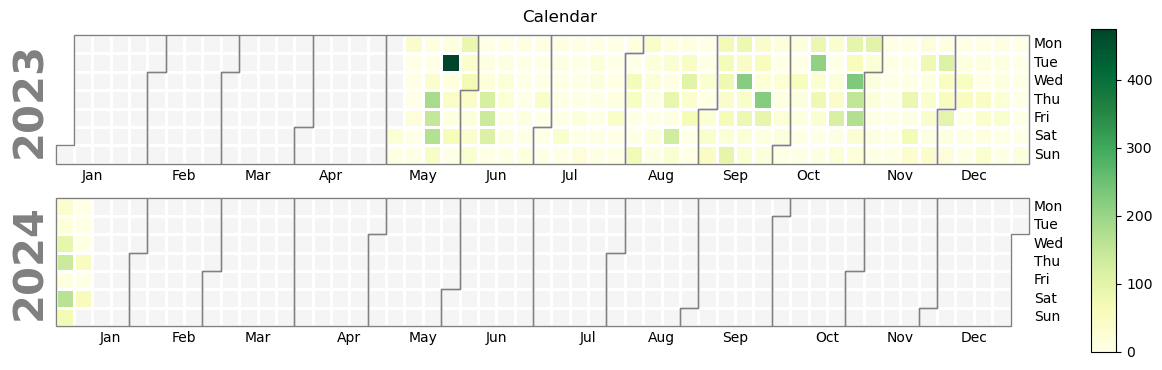

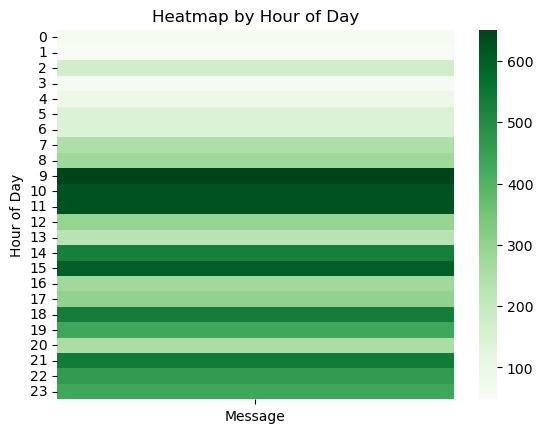

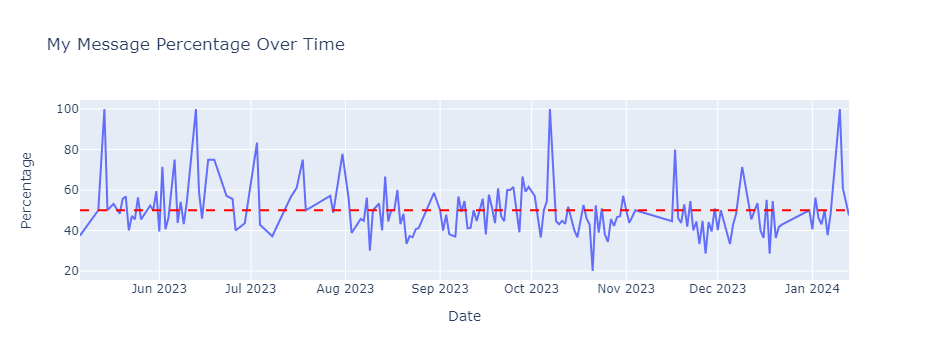

In [16]:
Message_count()

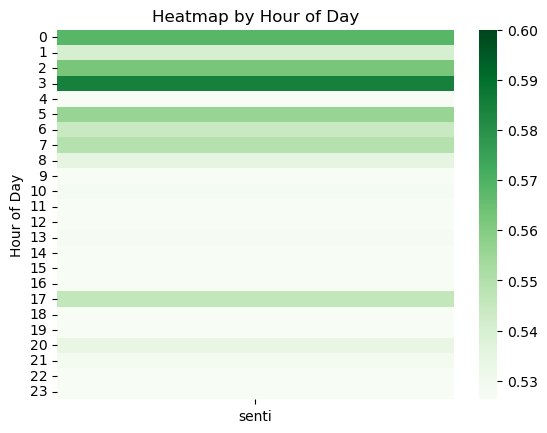

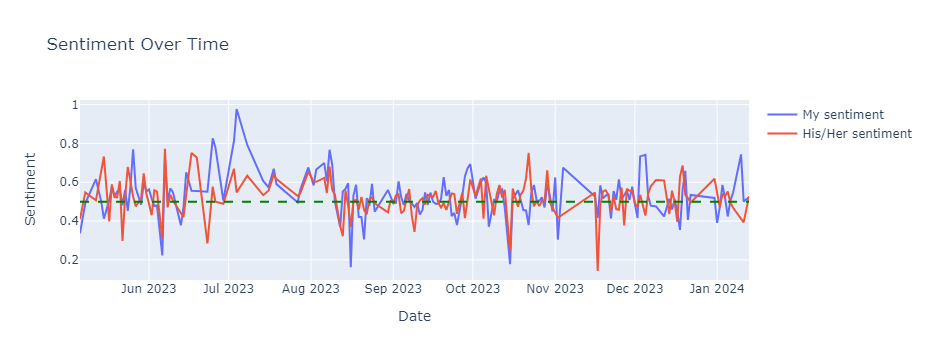

In [9]:
Sentiment()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\jhan4\AppData\Local\Temp\jieba.cache
Loading model cost 0.560 seconds.
Prefix dict has been built successfully.


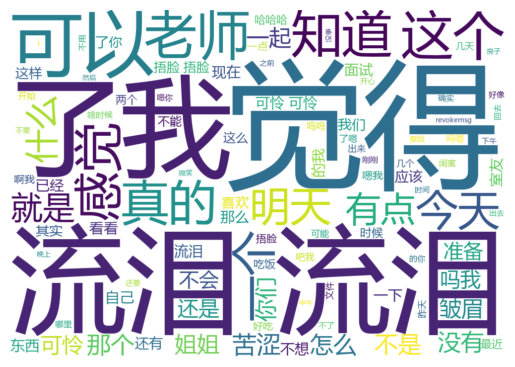

In [12]:
WordCloud()